# Benchmarking randomized circuits using Quantum state tomography
# For REAL backend (to draw violin plot)


In [1]:
def randomized_circuit(q_input, circ_number):
    from tqdm import tqdm
    from qiskit.compiler import transpile
    from qiskit.transpiler.passes import RemoveBarriers
    from qiskit import QuantumCircuit
    from qiskit.circuit.library import XGate, YGate, ZGate, IGate
    import numpy as np

    ## define easy and hard gates
    easy_gate = ['u3', 'id']
    hard_gate = ['cx']
    twirling = ['id', 'x', 'y', 'z']

    ## transpile the input gate to the equivalent gate with easy and hard gates basis
    q_transform = transpile(q_input, basis_gates=['u3', 'cx', 'id'], optimization_level=3)

    random_circuit_set = []
    running_qubits = [0, 1, 2]

    ## set easy_layer sets and hard_layer sets
    easy_layer = []
    hard_layer = []
    easy_layer_comp = []
    hard_seeker = False
    for gate in q_transform.data:
        if gate[0].name in hard_gate:
            hard_layer.append(gate)
            hard_seeker=True
            easy_layer.append(easy_layer_comp)
            easy_layer_comp=[]
        elif gate[0].name in easy_gate:
            if hard_seeker:
                hard_seeker=False
                easy_layer_comp=[]
            easy_layer_comp.append(gate)
    easy_layer.append(easy_layer_comp)

    def random_T():
        rand_value = np.random.randint(4)
        if rand_value == 0:
            return XGate()
        elif rand_value == 1:
            return YGate()
        elif rand_value == 2:
            return ZGate()
        elif rand_value == 3:
            return IGate()

    depth_easy = len(easy_layer)
    depth_hard = len(hard_layer)
    depth = depth_easy + depth_hard

    for _ in tqdm(np.arange(circ_number)):
        T_set = []
        for _ in range(depth_hard):
            T_comp = []
            for _ in running_qubits:
                T = random_T()
                T_comp.append(T)
            T_set.append(T_comp)

        q_out = QuantumCircuit(q_transform.num_qubits)
        for ind in range(depth//2 + 1):
            # Hard layer
            if ind > 0:
                q_out.barrier()
                q_out.compose(hard_layer[ind - 1][0], hard_layer[ind - 1][1], inplace=True)
                q_out.barrier()
            # Tc + easy + T layer (No Tc at the first layer, no T at the final layer)
            ## Tc
            q_temp = QuantumCircuit(q_transform.num_qubits)
            if ind > 0:
                q_temp.compose(hard_layer[ind - 1][0].reverse_ops(), hard_layer[ind - 1][1], inplace=True)
                for T_ind, T in zip(running_qubits, T_set[ind-1]):
                    q_temp.compose(T.reverse_ops(), [T_ind], inplace=True)
                q_temp.compose(hard_layer[ind - 1][0], hard_layer[ind - 1][1], inplace=True)
            ## easy
            for sub_ind in np.arange(len(easy_layer[ind])):
                q_temp.compose(easy_layer[ind][sub_ind][0], easy_layer[ind][sub_ind][1], inplace=True)
            ## T
            if (ind < depth//2):
                for T_ind, T in zip(running_qubits, T_set[ind]):
                    q_temp.compose(T, [T_ind], inplace=True)
            q_temp = transpile(q_temp, basis_gates=['id', 'u3', 'cx'], optimization_level=3)

            q_out.compose(q_temp, range(q_transform.num_qubits), inplace=True)
        q_out = RemoveBarriers()(q_out)
        q_out = transpile(q_out, basis_gates=['id', 'u3', 'cx'], optimization_level=3)

        random_circuit_set.append(q_out)

    return random_circuit_set

In [2]:
def job_mapper(n_circ_index, n_iter_index, l, n_circ_list, n_iter, N=30):
    M = n_iter * sum(n_circ_list[:n_circ_index]) + n_circ_list[n_circ_index] * n_iter_index + 1 + l
    return M // N, M % N

def rc_real_backend_execute_for_violin(original_circuit, randomized_circuits, backend, initial_layout, schedule, n_circ_list, n_iter, shots=1000):
    from qiskit.compiler import transpile
    from qiskit import execute

    job_dictionary = {}

    if len(randomized_circuits) < sum(n_circ_list) * n_iter:
        return ValueError

    job_circ_list = []
    original_circuit_ = original_circuit.copy()
    original_circuit_.measure_all()
    original_circuit_ = transpile(original_circuit_, backend=backend, initial_layout=initial_layout, scheduling_method=schedule, optimization_level=3)
    job_circ_list.append([])
    job_circ_list[0].append(original_circuit_)
    k = 0
    for i in range(len(n_circ_list)):
        for j in range(n_iter):
            for l in range(n_circ_list[i]):
                rc = randomized_circuits[k]
                k += 1
                rc_ = rc.copy()
                rc_.measure_all()
                rc_ = transpile(rc_, backend=backend, initial_layout=initial_layout, scheduling_method=schedule, optimization_level=3)
                A, B = job_mapper(i, j, l, n_circ_list, n_iter)
                if A >= len(job_circ_list):
                    job_circ_list.append([])
                job_circ_list[A].append(rc_)
                job_dictionary[(i, j, l)] = (A, B)

    job_list = []
    for job_circs in job_circ_list:
        job = execute(job_circs, backend=backend, shots=shots)
        job_list.append(job)

    return job_list, job_dictionary

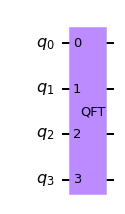

In [18]:
from qiskit.circuit.random import random_circuit
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

target = QFT(4)
# target.h(0) target.cx(0, 1)
# target.cx(1, 2)
# target.cx(2, 3)
# target.cx(3, 4)
target.draw('mpl')

100%|██████████| 5000/5000 [16:45<00:00,  4.97it/s]


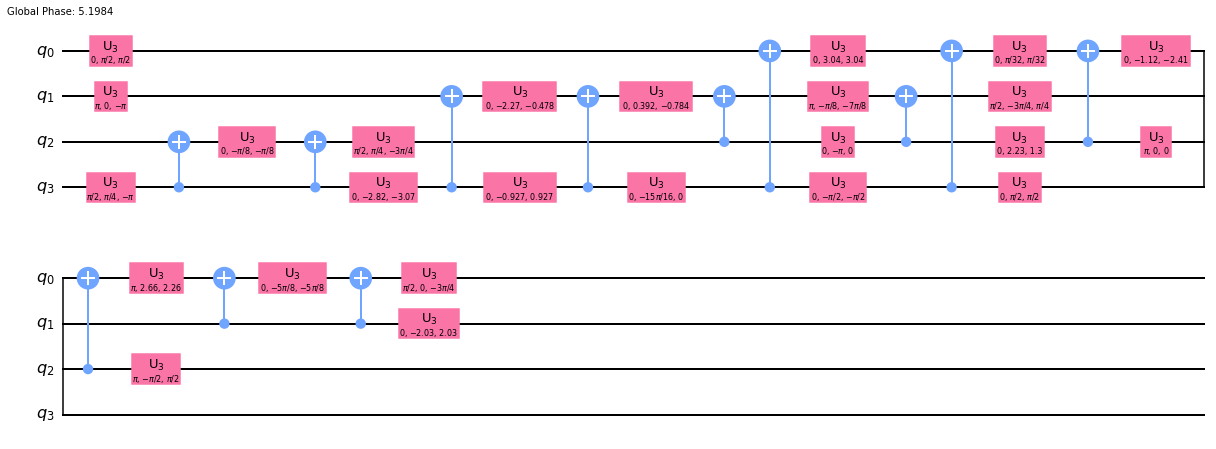

In [4]:
rc_circs = randomized_circuit(target, 5000)
rc_circs[0].draw('mpl')

In [20]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-skku', group='snu', project='snu-students')
backend = provider.get_backend('ibmq_jakarta')
initial_layout = [3, 4, 5, 6]
schedule = 'alap'
n_circ_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
n_iter = 10

ibmqfactory.load_account:WARNING:2022-06-28 18:17:45,693: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
job_list, job_dict = rc_real_backend_execute_for_violin(target, rc_circs, backend, initial_layout, schedule, n_circ_list, n_iter, shots=10000)

In [86]:
[job_list[i].result().get_counts() for i in range(54)]

[[{'000': 1288,
   '001': 1234,
   '010': 1395,
   '011': 1099,
   '100': 1369,
   '101': 1062,
   '110': 1421,
   '111': 1132},
  {'000': 1086,
   '001': 1250,
   '010': 1139,
   '011': 1173,
   '100': 1400,
   '101': 1320,
   '110': 1276,
   '111': 1356},
  {'000': 1365,
   '001': 1254,
   '010': 1454,
   '011': 1027,
   '100': 1331,
   '101': 1219,
   '110': 1127,
   '111': 1223},
  {'000': 1068,
   '001': 1180,
   '010': 1325,
   '011': 1242,
   '100': 1311,
   '101': 1224,
   '110': 1223,
   '111': 1427},
  {'000': 1267,
   '001': 1184,
   '010': 1231,
   '011': 1303,
   '100': 1342,
   '101': 1133,
   '110': 1464,
   '111': 1076},
  {'000': 1208,
   '001': 1343,
   '010': 1322,
   '011': 1158,
   '100': 1237,
   '101': 1187,
   '110': 1475,
   '111': 1070},
  {'000': 1148,
   '001': 1341,
   '010': 1255,
   '011': 1157,
   '100': 1368,
   '101': 1249,
   '110': 1240,
   '111': 1242},
  {'000': 1280,
   '001': 1165,
   '010': 1385,
   '011': 1134,
   '100': 1407,
   '101': 1159,
 

In [89]:
def tvd_benchmark_rc_circuit_for_real_post_call(original_circuit, randomized_circuits, jobs, job_dic,  n_circ_list, n_iter, shots=1000):
    from qiskit.quantum_info import Statevector

    #n_random_circs = len(randomized_circuits)
    state_vector = Statevector.from_instruction(original_circuit)
    ideal_probabilities = state_vector.probabilities_dict()

    bare_counts = jobs[0].result().get_counts()[0]
    bare_counts = {key: value for key, value in sorted(bare_counts.items())}

    #rc_counts_list = []
    #for k in range(n_random_circs):
    #    rc_counts_list.append(job.result().get_counts()[1 + k])
    #keys = set().union(*rc_counts_list)
    #rc_counts = {k: sum([cnts.get(k, 0) for cnts in rc_counts_list]) for k in keys}
    #rc_counts = {key: value for key, value in sorted(rc_counts.items())}

    tvd_bare = sum(0.5 * abs(ideal_probabilities.get(key, 0) - bare_counts.get(key, 0) / shots)
                   for key in ideal_probabilities.keys() | bare_counts.keys())
    tvd_random_double_set = []
    for i in range(len(n_circ_list)):
        tvd_random_single_set = []
        for j in range(n_iter):
            rc_counts_list = []
            for l in range(n_circ_list[i]):
                index = job_dic[(i, j, l)]
                rc_counts_temp = jobs[index[0]].result().get_counts()[index[1]]
                rc_counts_list.append(rc_counts_temp)
            keys = set().union(*rc_counts_list)
            rc_counts = {k: sum([cnts.get(k, 0) for cnts in rc_counts_list]) for k in keys}
            rc_counts = {key: value for key, value in sorted(rc_counts.items())}
            tvd_random = sum(0.5 * abs(ideal_probabilities.get(key, 0) - rc_counts.get(key, 0) / shots / n_circ_list[i])
                             for key in ideal_probabilities.keys() | rc_counts.keys())
            tvd_random_single_set.append(tvd_random)
        tvd_random_double_set.append(tvd_random_single_set)
    return tvd_random_double_set
    #print(ideal_probabilities)
    #print('Original TVD: ', tvd_bare, bare_counts)
    #print('Randomized TVD: ', tvd_random, rc_counts)

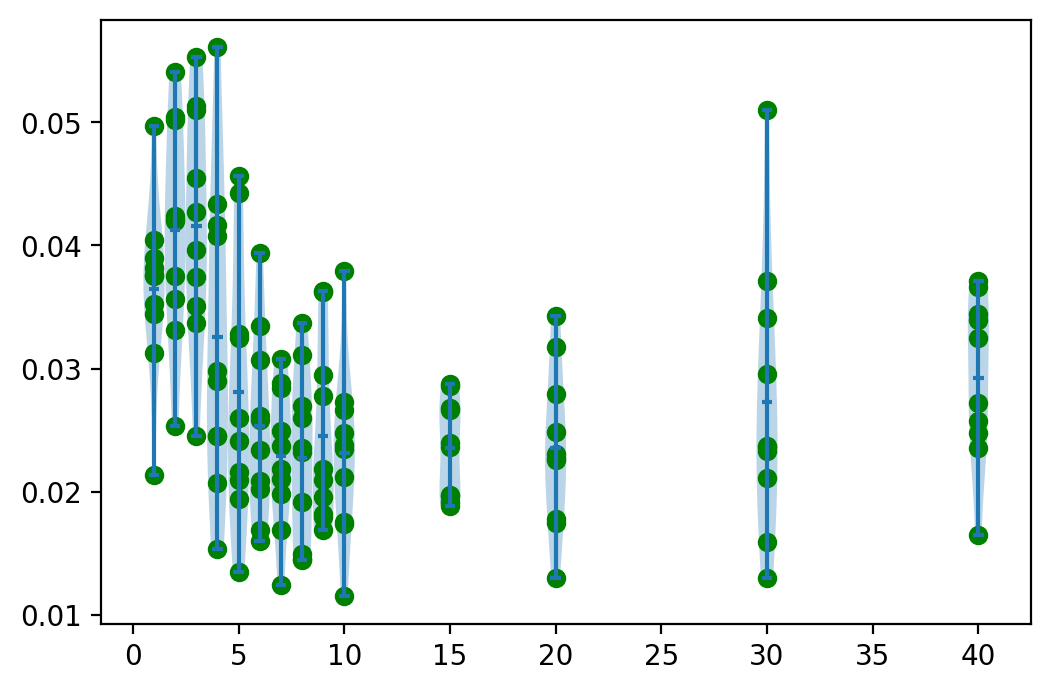

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

result = tvd_benchmark_rc_circuit_for_real_post_call(target, rc_circs, job_list, job_dict, [1,2,3,4,5,6,7,8,9,10,15,20,30,40], 10, shots=10000)

plt.figure(dpi=200)
for r in np.transpose(result):
    plt.plot([1,2,3,4,5,6,7,8,9,10,15,20,30,40], r, linestyle='None', marker='o', color='g')
plt.violinplot(result, [1,2,3,4,5,6,7,8,9,10,15,20,30,40], points=20, widths=1,showmeans=True)
# plt.stripplot(result, [1,2,3,4,5,6,7,8,9,10,15,20,30,40], points=20, widths=1,showmeans=True)
# sb.violinplot(result, [1,2,3,4,5,6,7,8,9,10,15,20,30,40])
plt.show()

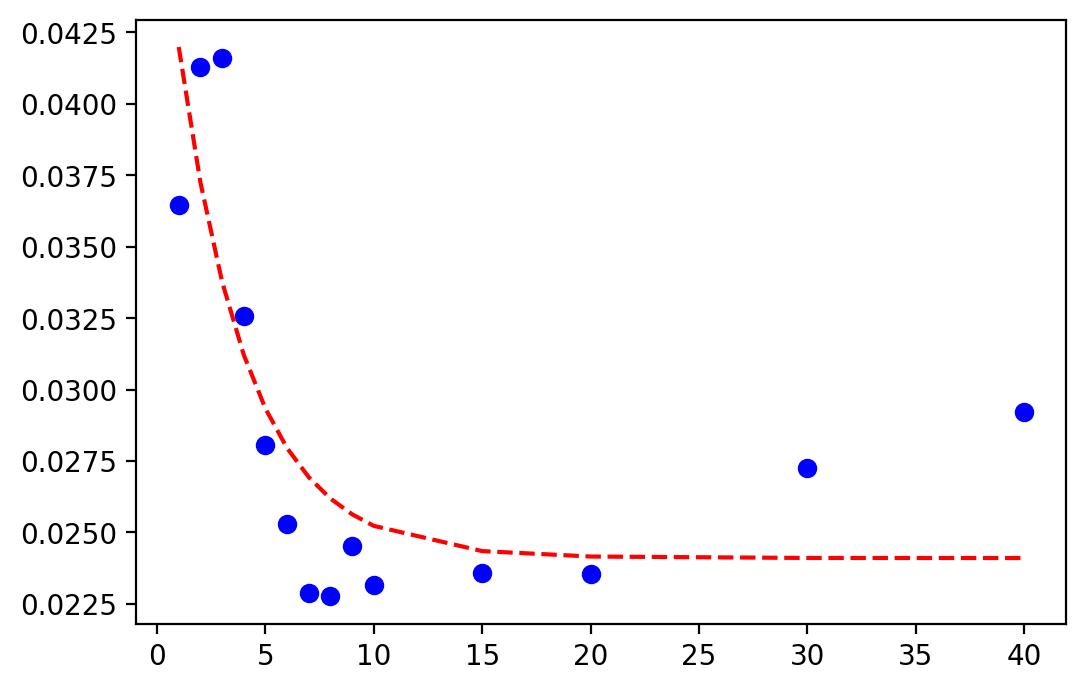

0.999515678778263


In [117]:
def objective(x, a, b, c):
    return a * np.exp(-c * x) + b

from scipy.optimize import curve_fit

popt, _ = curve_fit(objective, [1,2,3,4,5,6,7,8,9,10,15,20,30,40], np.mean(result, axis=1))
a, b, c = popt
y_line = [objective(res, a, b, c) for res in [1,2,3,4,5,6,7,8,9,10,15,20,30,40]]
plt.figure(dpi=200)
plt.plot([1,2,3,4,5,6,7,8,9,10,15,20,30,40], np.mean(result, axis=1), 'o', color='blue')
plt.plot([1,2,3,4,5,6,7,8,9,10,15,20,30,40], y_line, '--', color='red')
plt.show()

residuals = np.array(np.mean(result, axis=1)) - np.array(y_line)
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((np.array(np.mean(result, axis=1)) - np.array(np.mean(np.mean(result, axis=1))) ** 2))
r_squared = 1 - (ss_res / ss_tot)

print(r_squared)

In [141]:
import dill

dill.dump_session('3q_fourier_on_jakarta')

ValueError: ctypes objects containing pointers cannot be pickled